In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.optimizers import Nadam, Adam
from tensorflow.keras.initializers import lecun_normal
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2025-01-25 14:37:03.687303: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-25 14:37:03.694900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737812223.703594 4034415 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737812223.706279 4034415 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 14:37:03.715188: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

AttributeError: _ARRAY_API not found

In [3]:
df = pd.read_csv('PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [4]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

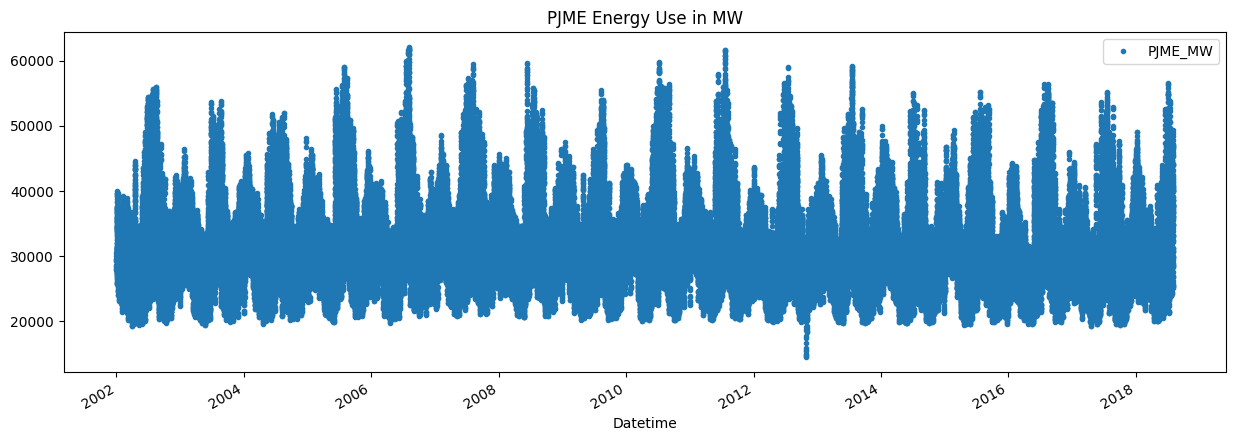

In [5]:
df.plot(style='.', figsize=(15, 5), title='PJME Energy Use in MW')
plt.show()

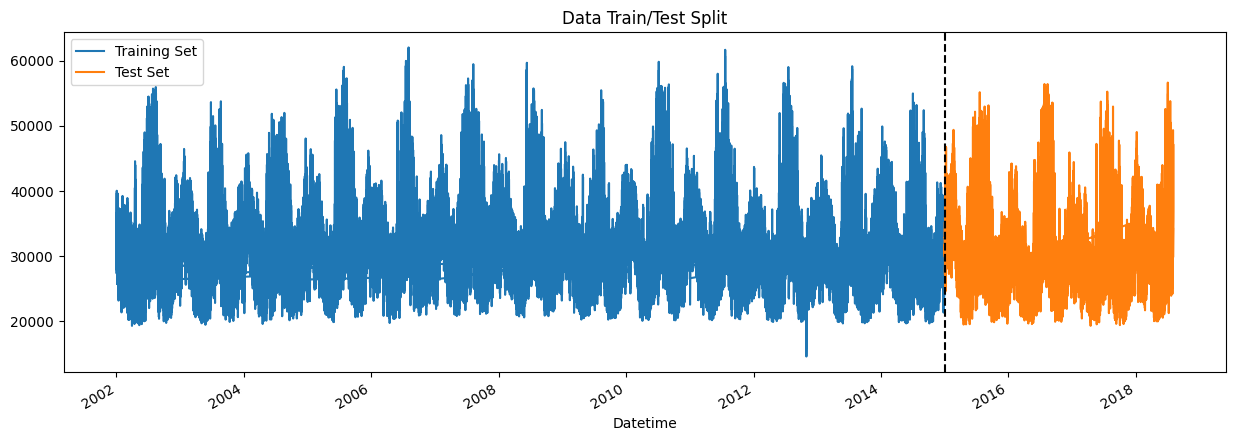

In [6]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [7]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [8]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [10]:
X_train_norm.shape

(113926, 6)

In [11]:
class MCDropout(Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [14]:
model_MC = Sequential([InputLayer(input_shape=(6,)),
             MCDropout(0.4),
			 Dense(1000, activation="selu", kernel_initializer="lecun_normal"),
             MCDropout(0.4),
             Dense(2000, activation="selu", kernel_initializer="lecun_normal"),
             MCDropout(0.4),
             Dense(2000, activation="selu", kernel_initializer="lecun_normal"),
			 MCDropout(0.4),
             Dense(1000, activation="selu", kernel_initializer="lecun_normal"),
			 MCDropout(0.4),
             Dense(1, activation=None)
			 ])

/users/eleves-b/2024/ahmed.khairaldin/.local/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2025-01-25 14:39:12.372811: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-01-25 14:39:12.372826: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: roumanie.polytechnique.fr
2025-01-25 14:39:12.372829: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: roumanie.polytechnique.fr
2025-01-25 14:39:12.372884: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.142.0
2025-01-25 14:39:12.372892: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 550.

In [15]:
model_MC.compile(loss="mean_squared_error",
              optimizer="Nadam",
              metrics=["mean_squared_error"])

In [16]:
history_MC = model_MC.fit(X_train_norm, y_train, epochs=200, validation_split=0.2, callbacks=[callback])

Epoch 1/200
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 80s 28ms/step - loss: 85786384.0000 - mean_squared_error: 85786384.0000 - val_loss: 32873092.0000 - val_mean_squared_error: 32873092.0000
Epoch 2/200
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 79s 28ms/step - loss: 30796106.0000 - mean_squared_error: 30796106.0000 - val_loss: 32423472.0000 - val_mean_squared_error: 32423472.0000
Epoch 3/200
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 79s 28ms/step - loss: 29155312.0000 - mean_squared_error: 29155312.0000 - val_loss: 28731566.0000 - val_mean_squared_error: 28731566.0000
Epoch 4/200
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 79s 28ms/step - loss: 27965454.0000 - mean_squared_error: 27965454.0000 - val_loss: 28978618.0000 - val_mean_squared_error: 28978618.0000
Epoch 5/200
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 79s 28ms/step - loss: 27654236.0000 - mean_squared_error: 27654236.0000 - val_loss: 28067856.0000 - val_mean_squared_error: 28067856.0000
Epoch 6/200
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 80s 28ms/step - loss: 26919844.0000 - mean_squared_e

In [17]:
# Sauvegarde du modèle
model_MC.save('model_MC.h5')

  1/983 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step

983/983 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
983/983 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
983/983 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
983/983 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
983/983 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


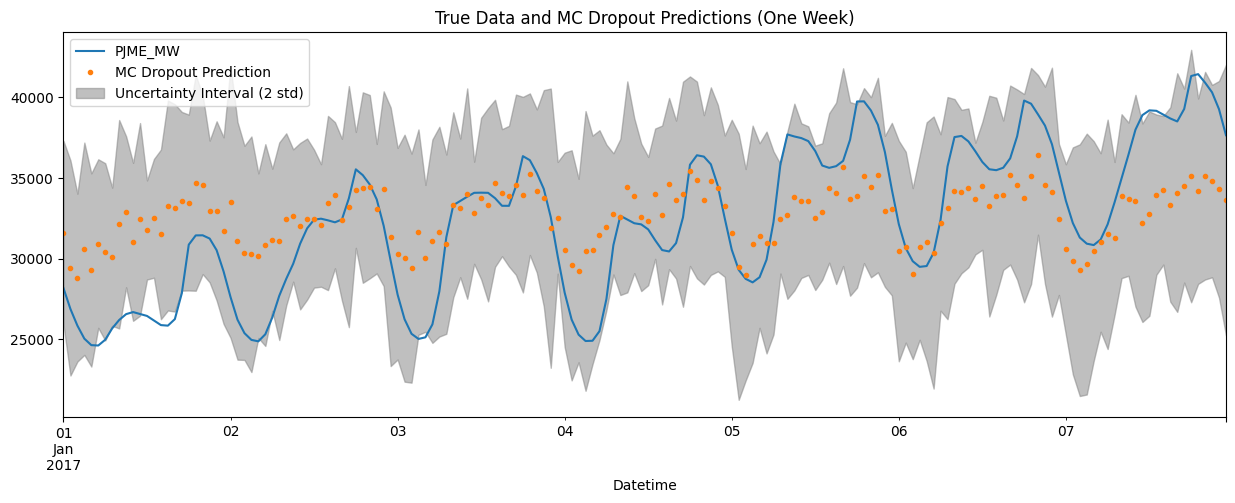

In [22]:
# Fonction pour effectuer les prédictions avec MC Dropout
def predict_with_uncertainty(model, X_test, n_iter=10):
    predictions = []
    
    # Effectuer plusieurs passes (par exemple, n_iter = 100)
    for _ in range(n_iter):
        y_pred = model.predict(X_test)  # Prédiction avec dropout
        predictions.append(y_pred)  # Collecter les prédictions

    predictions = np.array(predictions)  # Convertir en tableau numpy
    return predictions


# Effectuer les prédictions avec MC Dropout
n_iter = 20  # Nombre de passes pour obtenir l'incertitude
predictions = predict_with_uncertainty(model_MC, X_test_norm, n_iter)

# Moyenne et écart-type des prédictions
mean_predictions = predictions.mean(axis=0)
std_predictions = predictions.std(axis=0)

# Ajouter toutes les prédictions et les intervalles dans un DataFrame
test['predictions'] = mean_predictions.flatten()  # Prédiction moyenne
test['std_predictions'] = std_predictions.flatten()  # Intervalle d'incertitude


# Filtrer les données pour une semaine spécifique (ex. une semaine de janvier 2010)
start_date = '2017-01-01'
end_date = '2017-01-07'
test.index = pd.to_datetime(test.index)
test.sort_index(inplace=True)
df_week = test.loc[start_date:end_date]

# Tracer les prédictions et les vraies valeurs
fig, ax = plt.subplots(figsize=(15, 5))

# Tracer les valeurs réelles (True Data)
df_week[['PJME_MW']].plot(ax=ax, label='True Data')

# Tracer les prédictions (Prediction)
df_week['predictions'].plot(ax=ax, style='.', label='MC Dropout Prediction')

# Affichage de l'incertitude (intervalle de confiance à 95% avec 2 écarts-types)
ax.fill_between(df_week.index, df_week['predictions'] - 2 * df_week['std_predictions'], 
                df_week['predictions'] + 2 * df_week['std_predictions'], 
                color='gray', alpha=0.5, label='Uncertainty Interval (2 std)')

# Configurations de l'affichage
plt.legend(loc='best')
ax.set_title('True Data and MC Dropout Predictions (One Week)')
plt.show()